In [160]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,LSTM,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization

from keras.optimizers import SGD, RMSprop, Adam

from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import cPickle as pickle

from keras.callbacks import RemoteMonitor
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error


In [155]:
def plot_predictions_vs_truth(pred,truth,nr_examples):

    for index in range(nr_examples):
        plt.plot(pred[index],'b')
        plt.plot(truth[index],'r')
        plt.show()

In [2]:
base_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/dmc/deep-learning-time-series-analysis/"
resources_folder = "resources/"

In [3]:
data = pd.read_csv('../data/train.csv', sep='|')
data['itemsPurchased'] = (data['revenue'] / data['price']).astype(int)
data['purchase'] = data['itemsPurchased'].apply(lambda x: 1 if x >= 1 else int(x))
data

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,itemsPurchased,purchase
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00,0,0
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00,0,0
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00,0,0
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55,1,1
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14,1,1
5,6,1,3661,0,1,13.66,0,0,1,10.03,10.03,1,1
6,7,1,3856,1,1,3.03,0,0,1,3.58,3.58,1,1
7,8,1,16963,0,1,8.78,1,0,0,8.75,0.00,0,0
8,9,1,14560,0,1,10.84,1,0,0,12.04,0.00,0,0
9,10,1,4853,1,1,9.12,1,0,0,8.75,0.00,0,0


In [4]:
# data[['lineID','itemsPurchased']].groupby(['itemsPurchased']).agg(['count'])

In [124]:
nr_days = data['day'].max()+1
print("Nr Days = %d"%nr_days)

Nr Days = 93


In [125]:
nr_train_days = int(0.7*nr_days)
nr_test_days = nr_days - nr_train_days

print("Train days: %d"%nr_train_days)
print("Test days: %d"%nr_test_days)

Train days: 65
Test days: 28


In [126]:
def get_dict_for_pid(df, pid):
    filtered = df.loc[df['pid'] == pid].set_index('day')
    return filtered.to_dict(orient='index')

def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def get_timeseries_for_data(data):

    uniquePids = sorted(data['pid'].unique())
    
    timeseries = [get_dict_for_pid(data, pid) for pid in tqdm(uniquePids)]
    
    return timeseries

In [128]:
timeseries = get_timeseries_for_data(data)

In [9]:
save_obj(timeseries,base_path+resources_folder+"timeseries_v2")

In [129]:
timeseries = load_obj(base_path+resources_folder+"timeseries_v2")

In [11]:
timeseries[0]

{10: {'adFlag': 0.0,
  'availability': 3.0,
  'basket': 0.0,
  'click': 1.0,
  'competitorPrice': 8.2200000000000006,
  'itemsPurchased': 0.0,
  'lineID': 198133.0,
  'order': 0.0,
  'pid': 1.0,
  'price': 10.08,
  'purchase': 0.0,
  'revenue': 0.0},
 21: {'adFlag': 0.0,
  'availability': 3.0,
  'basket': 0.0,
  'click': 1.0,
  'competitorPrice': 8.7100000000000009,
  'itemsPurchased': 0.0,
  'lineID': 430014.0,
  'order': 0.0,
  'pid': 1.0,
  'price': 10.08,
  'purchase': 0.0,
  'revenue': 0.0},
 33: {'adFlag': 0.0,
  'availability': 3.0,
  'basket': 0.0,
  'click': 0.0,
  'competitorPrice': 8.2200000000000006,
  'itemsPurchased': 1.0,
  'lineID': 769328.0,
  'order': 1.0,
  'pid': 1.0,
  'price': 7.2800000000000002,
  'purchase': 1.0,
  'revenue': 7.2800000000000002},
 40: {'adFlag': 0.0,
  'availability': 3.0,
  'basket': 0.0,
  'click': 1.0,
  'competitorPrice': 8.2200000000000006,
  'itemsPurchased': 0.0,
  'lineID': 1011505.0,
  'order': 0.0,
  'pid': 1.0,
  'price': 8.4199999999

In [130]:
nr_examples = len(timeseries)
nr_features = 1

print("Nr Examples %d"%nr_examples)

Nr Examples 21928


# Purchase Matrix

In [132]:
def computePurchaseMatrix(timeseries,number_examples):
    purchase_matrix = np.zeros((number_examples,nr_days,1))
    
    for index in range(number_examples):
        current_dict = timeseries[index]
        for day in current_dict.keys():
            day_dict = current_dict[day]
            purchase = day_dict['purchase']
            purchase_matrix[index,day,0] = purchase
        
    return purchase_matrix

In [133]:
purchase_matrix = computePurchaseMatrix(timeseries,nr_examples)

print(purchase_matrix.shape)

(21928, 93, 1)


In [134]:
train_purchase_matrix = purchase_matrix[:,:nr_train_days,:]
test_purchase_matrix = purchase_matrix[:,nr_train_days:,:]

print(train_purchase_matrix.shape)
print(test_purchase_matrix.shape)

(21928, 65, 1)
(21928, 28, 1)


# Train/Test Matrix

In [136]:
train_matrix_without_first_day = train_purchase_matrix[:,1:,:]
test_matrix_without_first_day = test_purchase_matrix[:,1:,:]

print(train_matrix_without_first_day.shape)
print(test_matrix_without_first_day.shape)

(21928, 64, 1)
(21928, 27, 1)


In [137]:
train_matrix = np.insert(train_matrix_without_first_day,0,0,axis=1)
test_matrix = np.insert(test_matrix_without_first_day,0,0,axis=1)

print(train_matrix.shape)
print(test_matrix.shape)

(21928, 65, 1)
(21928, 28, 1)


In [238]:
def computeFeatureMatrix(timeseries,number_examples):
    
    data_matrix = np.zeros((number_examples,nr_days,nr_features))
    data_matrix.shape

    last_known_day = np.zeros(nr_features)
    for index in tqdm(range(number_examples)):
#     for index in range(number_examples):
        current_dict = timeseries[index]
        for day in range(nr_days):
            if day in current_dict:
                day_dict = current_dict[day]
                adFlag = day_dict['adFlag']
                availability = day_dict['availability']
                price = day_dict['price']

                if(math.isnan(day_dict['competitorPrice'])):
                    competitiorPrice = price
                else:
                    competitorPrice = day_dict['competitorPrice']
                
                day_sum = count_by_day_df.loc[day]
                
                last_known_day = [price,competitorPrice,availability,adFlag,day_sum]


            data_matrix[index,day] = last_known_day
            
    return data_matrix

In [237]:
# count_by_day_df = pd.read_csv('../data/count-by-day.csv')[['itemsPurchased','day']]
# count_by_day_df = count_by_day_df.set_index('day')
# count_by_day_df

# Ground Truth Matrix

In [166]:
def computeGroudTruthMatrix(timeseries,number_examples,number_days):
    groud_truth_matrix = np.zeros((number_examples,number_days,1))
    groud_truth_matrix.fill(-1)

    for index in range(number_examples):
        current_dict = timeseries[index]
        for day in current_dict.keys():
            day_dict = current_dict[day]
            items_purchase = day_dict['itemsPurchased']
            groud_truth_matrix[index,day,0] = items_purchase   
            
    
    return groud_truth_matrix

In [171]:
groud_truth_matrix = computeGroudTruthMatrix(timeseries,nr_examples,nr_days)

train_groud_truth_matrix = groud_truth_matrix[:,:nr_train_days,:]
test_groud_truth_matrix = groud_truth_matrix[:,nr_train_days:,:]

print(groud_truth_matrix.shape)
print(train_groud_truth_matrix.shape)
print(test_groud_truth_matrix.shape)

(21928, 93, 1)
(21928, 65, 1)
(21928, 28, 1)


In [234]:
final_train_matrix = train_matrix
final_test_matrix = test_matrix

# final_train_matrix = scaled_train_matrix
# final_test_matrix = scale_test_matrix

print(final_train_matrix.shape)
print(final_test_matrix.shape)

(21928, 65, 1)
(21928, 28, 1)


# Model 

In [28]:
model = Sequential()
model.add(BatchNormalization(input_shape=(nr_train_days,nr_features)))
# model.add(LSTM(2048, return_sequences=True))
model.add(LSTM(1024, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer = Adam(0.001))

In [212]:
model.fit(final_train_matrix, train_purchase_matrix, 
          nb_epoch=10, 
          batch_size = 256,
          callbacks = [RemoteMonitor()],
          verbose = 1)

Epoch 1/10
21928/21928 [==============================] - 26s - loss: 1.9385e-04     

In [213]:
train_error = model.evaluate(final_train_matrix, train_purchase_matrix)
print("Train MSE loss %f"%train_error)

21920/21928 [============================>.] - ETA: 0s 

In [214]:
models_folder = "models/v2"
save_path = base_path + models_folder
model.save(save_path+'bn_1-lstm-1024_20e.h5')

# Make predictions

In [222]:
nr_toy_examples = 1000

toy_train_matrix= train_matrix[:nr_toy_examples]
toy_test_matrix= test_matrix[:nr_toy_examples]

toy_test_purchase_matrix = test_purchase_matrix[:nr_toy_examples]

toy_test_groud_truth_matrix = test_groud_truth_matrix[:nr_toy_examples]

print(train_matrix.shape)
print(test_matrix.shape)

print(toy_train_matrix.shape)
print(toy_test_matrix.shape)

(21928, 65, 1)
(21928, 28, 1)
(1000, 65, 1)
(1000, 28, 1)


In [223]:
def make_predictions_on_test_set(current_train_matrix, current_test_matrix):
    
    for index in range(nr_test_days):

        print("-------Day %d --------"%index)
        print("Current Train Matrix: %s"%(current_train_matrix.shape,))
        print("Current Test Matrix: %s"%(current_test_matrix.shape,))

        train_matrix_except_first_day = current_train_matrix[:,1:,:]
        test_matrix_first_day = current_test_matrix[:,:1,:]

        print("Train matrix except first day: %s"%(train_matrix_except_first_day.shape,))
        print("Test matrix first day: %s"%(test_matrix_first_day.shape,))

        joined_matrix = np.concatenate([train_matrix_except_first_day,test_matrix_first_day],axis=1)

        print("Joined matrix: %s"%(joined_matrix.shape,))

        joined_predictions = model.predict(joined_matrix)
        prediction_for_last_day = joined_predictions[:,-1:]

        print("Prediction for one day matrix: %s"%(prediction_for_last_day.shape,))

        current_train_matrix = np.concatenate([train_matrix_except_first_day, prediction_for_last_day],axis=1)        
        current_test_matrix = current_test_matrix[:,1:,:]

        print("New Current Train matrix : %s"%(current_train_matrix.shape,))
        print("New Current Test matrix : %s"%(current_test_matrix.shape,))
        
    toy_test_predictions = current_train_matrix[:,-nr_test_days:,:]
    return toy_test_predictions

In [224]:
current_train_matrix = toy_train_matrix
current_test_matrix = toy_test_matrix

print("Current Train Matrix: %s"%(current_train_matrix.shape,))
print("Current Test Matrix: %s"%(current_test_matrix.shape,))


Current Train Matrix: (1000, 65, 1)
Current Test Matrix: (1000, 28, 1)


In [225]:
toy_test_predictions = make_predictions_on_test_set(current_train_matrix, current_test_matrix)

-------Day 0 --------
Current Train Matrix: (1000, 65, 1)
Current Test Matrix: (1000, 28, 1)
Train matrix except first day: (1000, 64, 1)
Test matrix first day: (1000, 1, 1)
Joined matrix: (1000, 65, 1)
Prediction for one day matrix: (1000, 1, 1)
New Current Train matrix : (1000, 65, 1)
New Current Test matrix : (1000, 27, 1)
-------Day 1 --------
Current Train Matrix: (1000, 65, 1)
Current Test Matrix: (1000, 27, 1)
Train matrix except first day: (1000, 64, 1)
Test matrix first day: (1000, 1, 1)
Joined matrix: (1000, 65, 1)
Prediction for one day matrix: (1000, 1, 1)
New Current Train matrix : (1000, 65, 1)
New Current Test matrix : (1000, 26, 1)
-------Day 2 --------
Current Train Matrix: (1000, 65, 1)
Current Test Matrix: (1000, 26, 1)
Train matrix except first day: (1000, 64, 1)
Test matrix first day: (1000, 1, 1)
Joined matrix: (1000, 65, 1)
Prediction for one day matrix: (1000, 1, 1)
New Current Train matrix : (1000, 65, 1)
New Current Test matrix : (1000, 25, 1)
-------Day 3 ---

In [226]:
toy_test_predictions.shape

(1000, 28, 1)

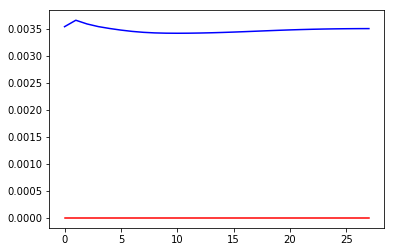

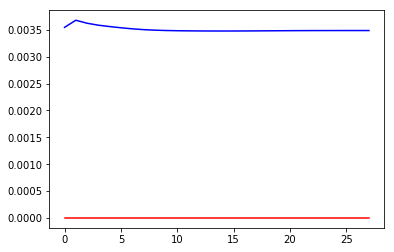

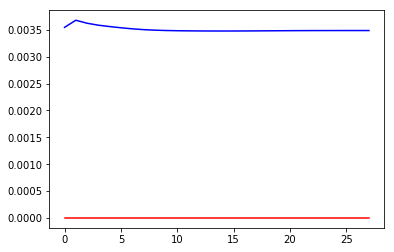

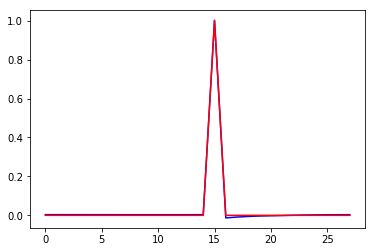

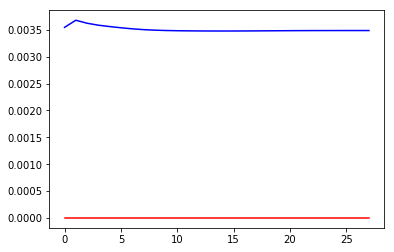

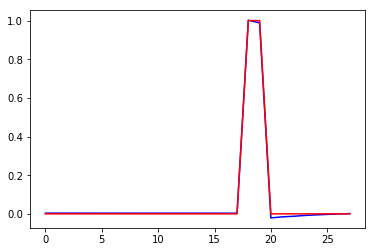

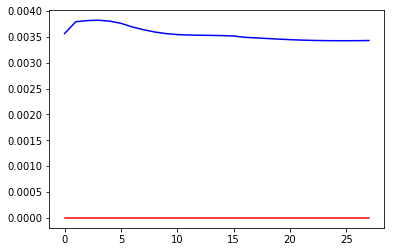

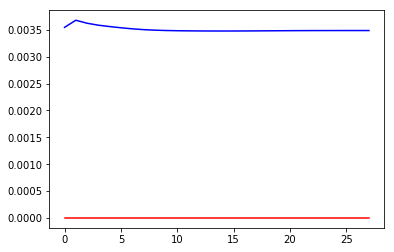

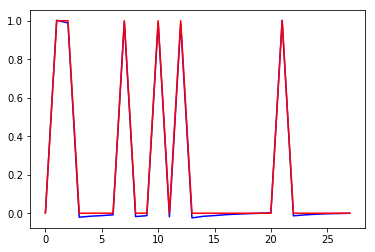

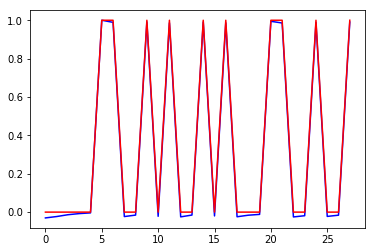

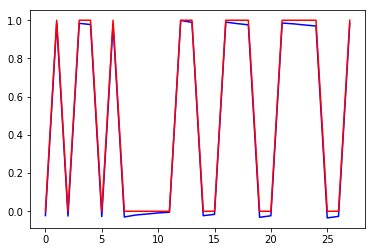

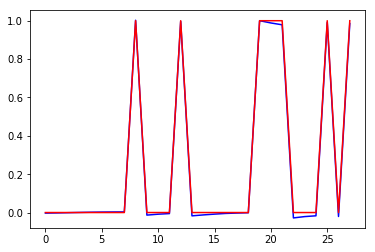

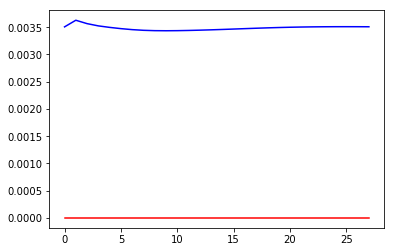

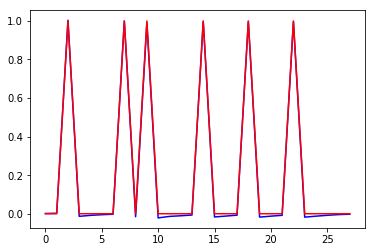

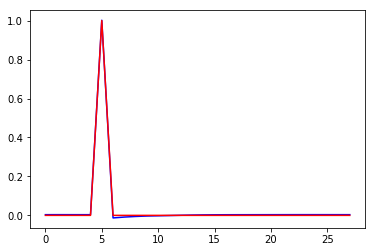

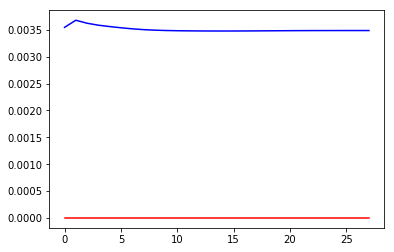

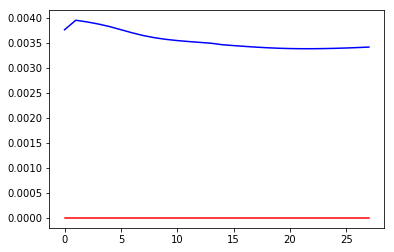

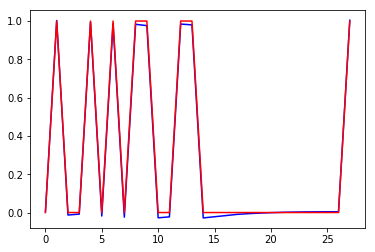

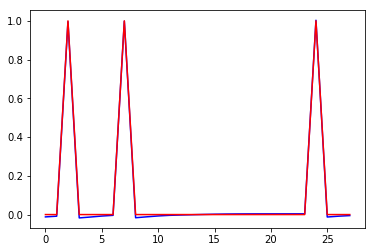

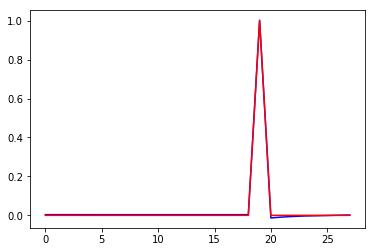

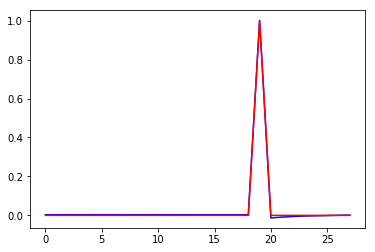

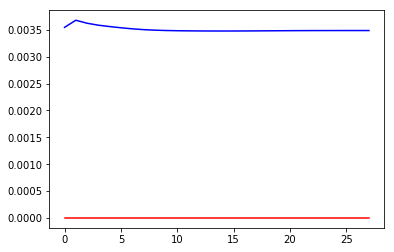

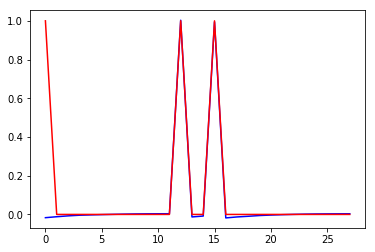

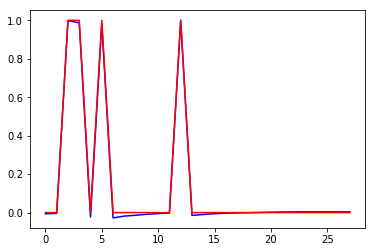

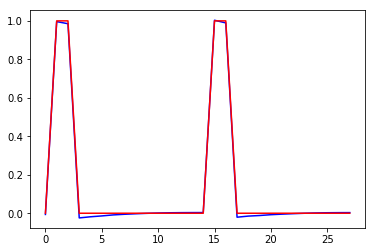

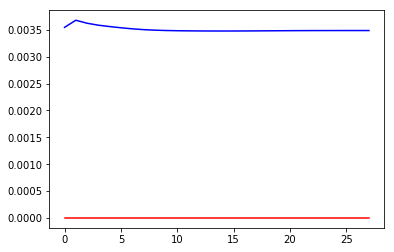

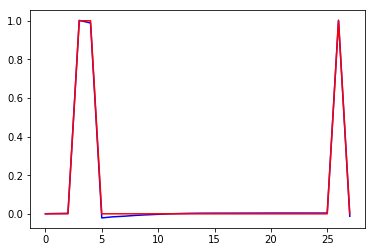

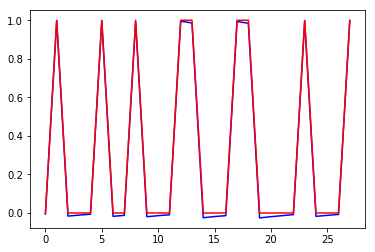

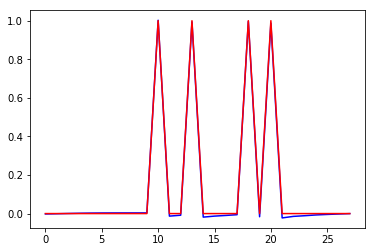

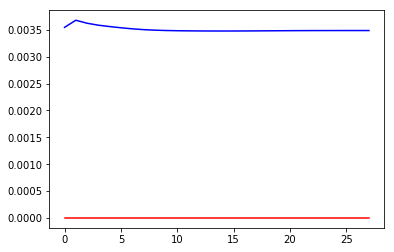

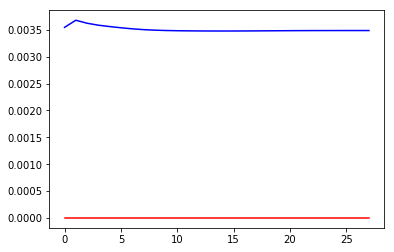

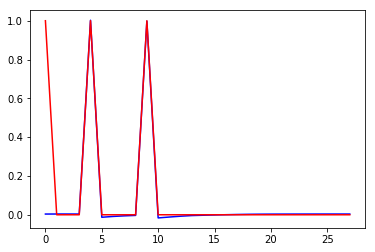

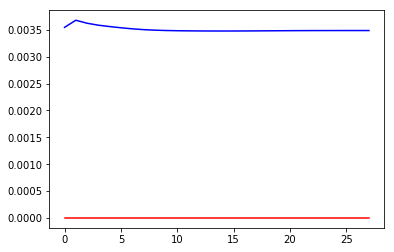

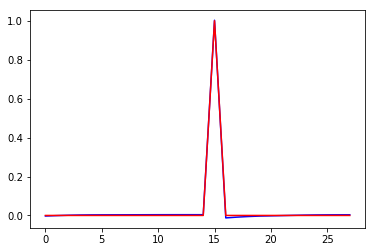

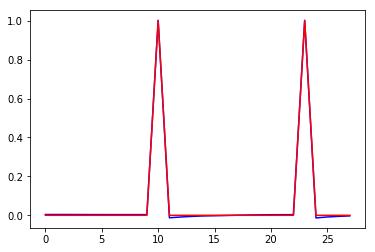

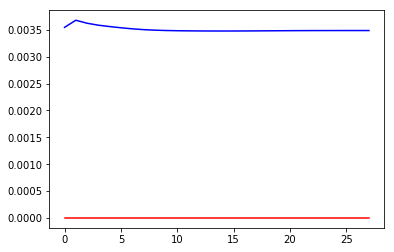

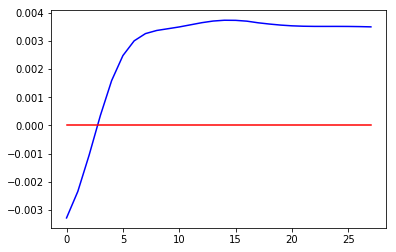

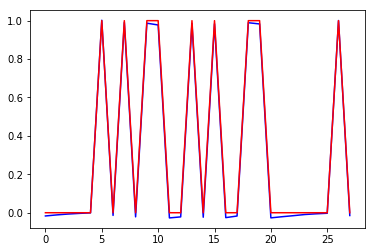

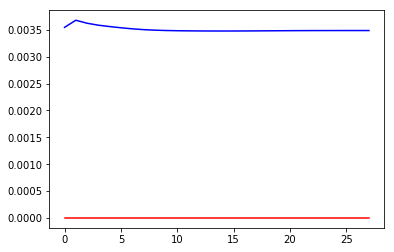

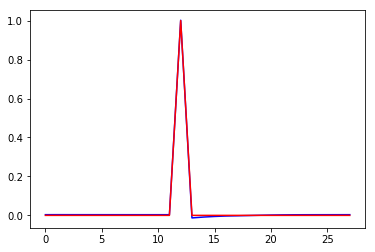

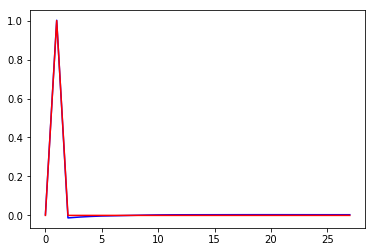

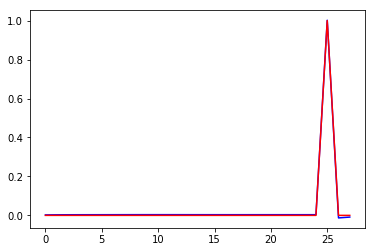

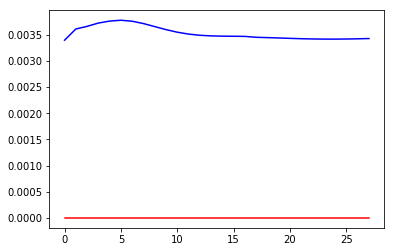

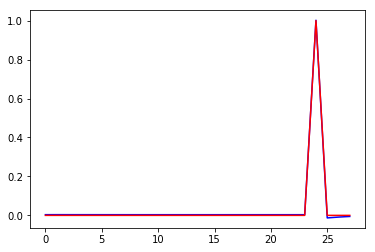

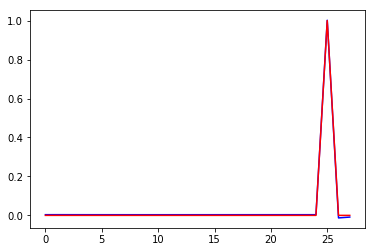

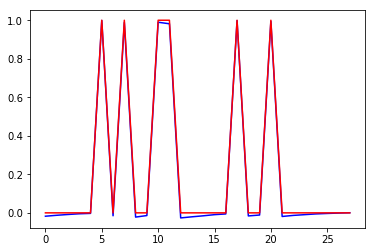

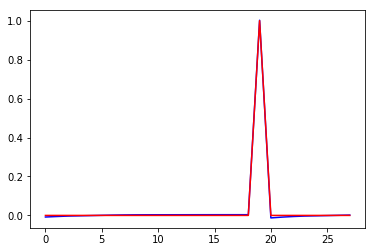

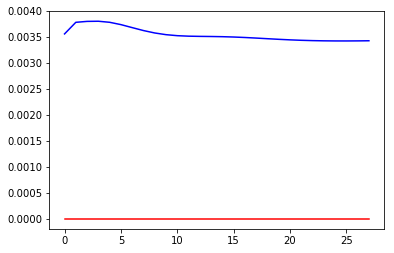

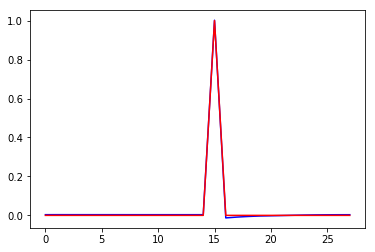

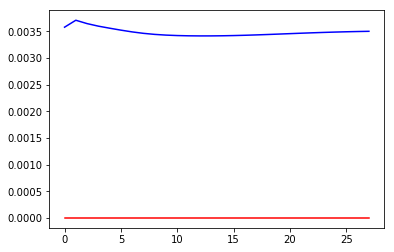

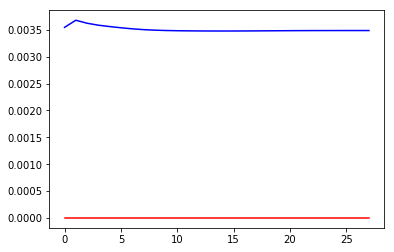

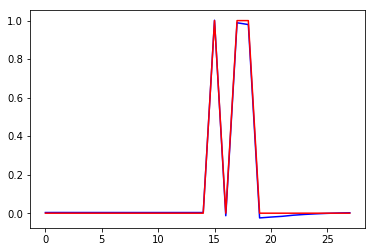

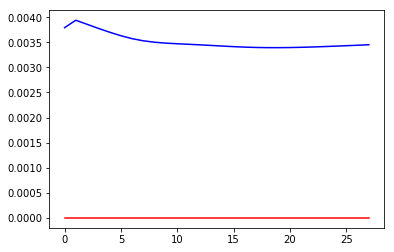

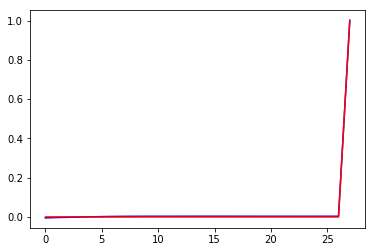

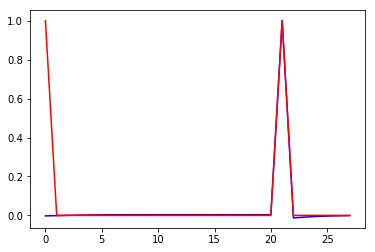

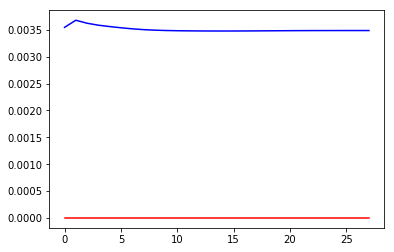

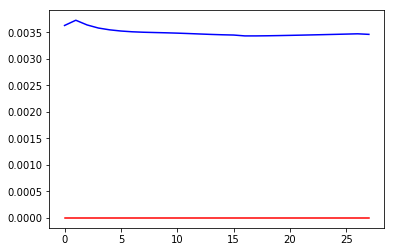

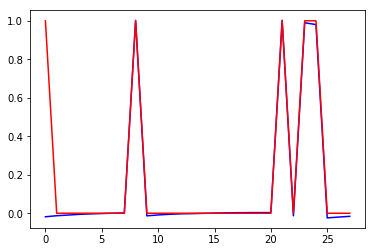

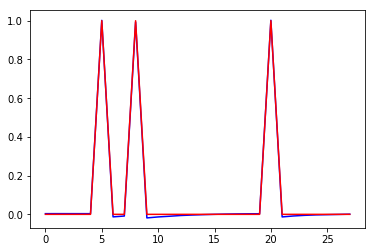

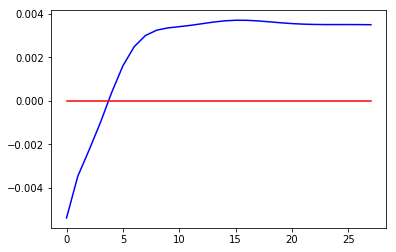

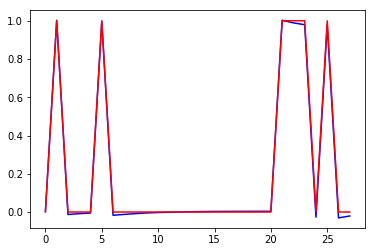

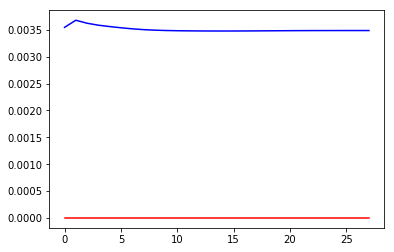

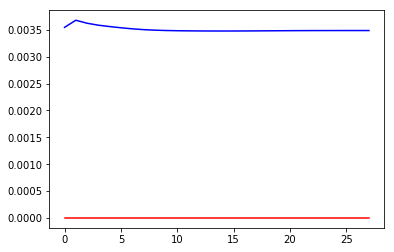

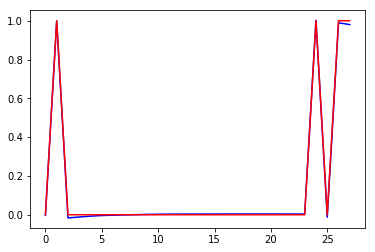

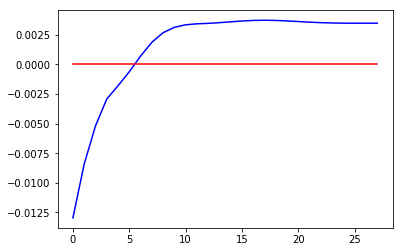

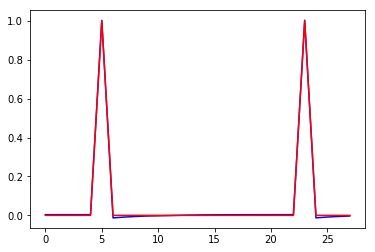

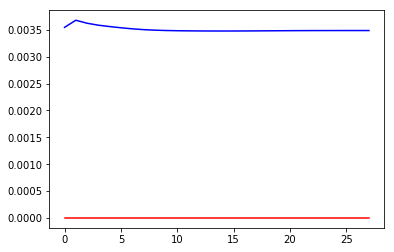

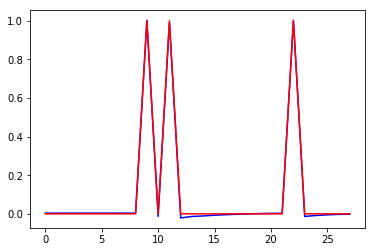

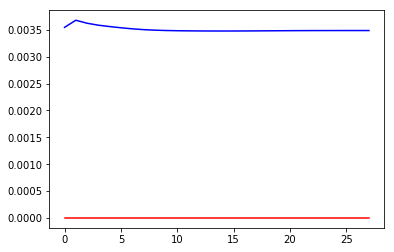

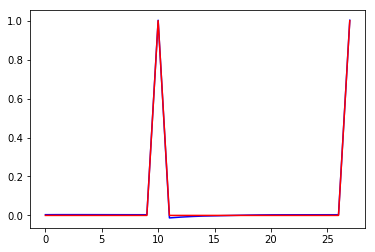

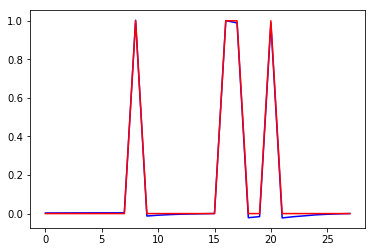

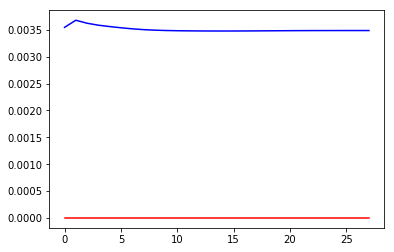

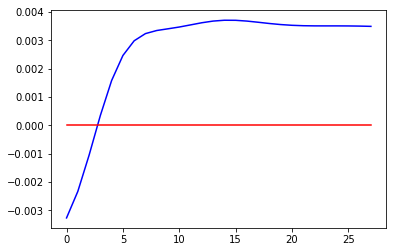

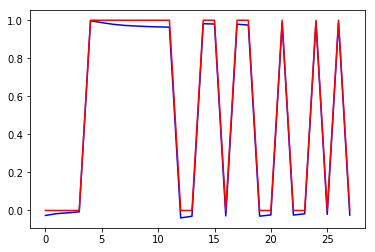

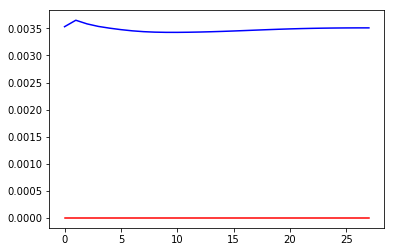

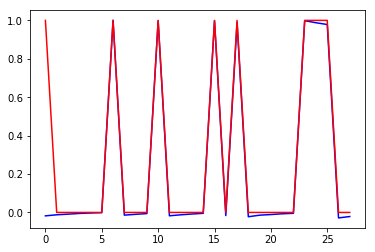

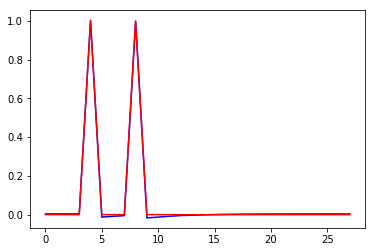

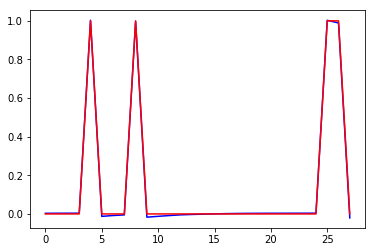

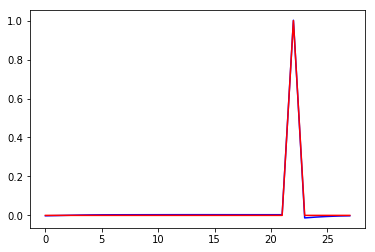

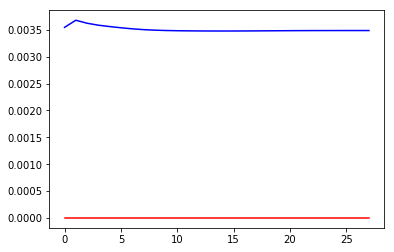

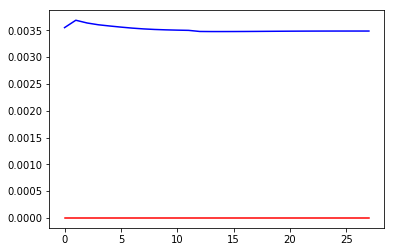

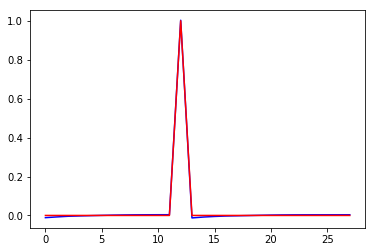

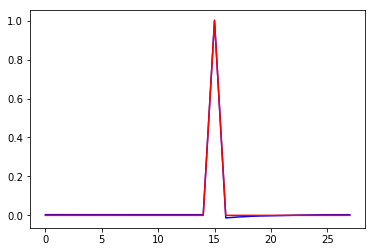

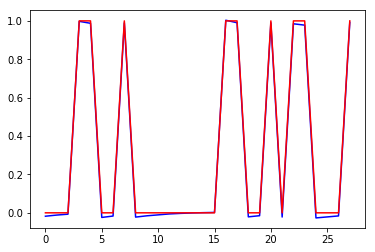

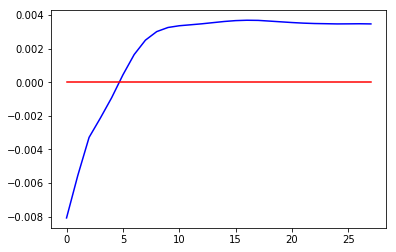

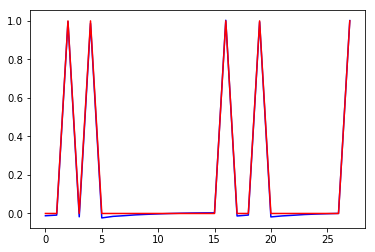

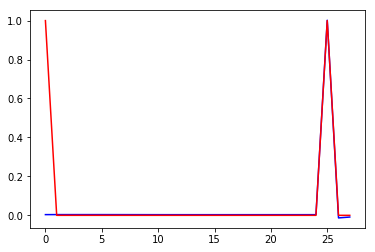

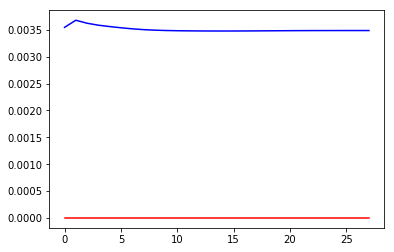

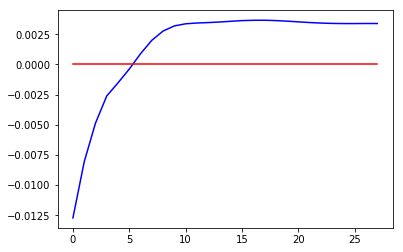

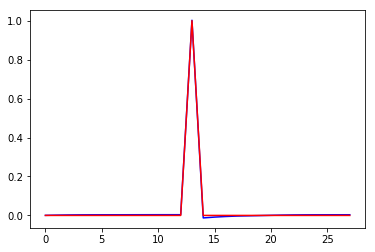

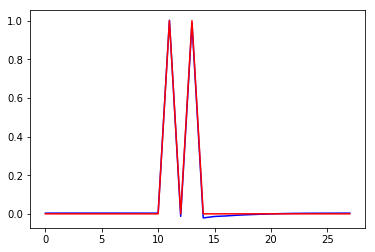

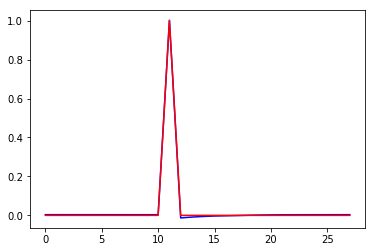

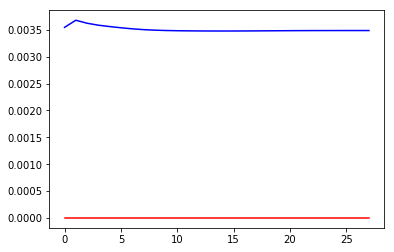

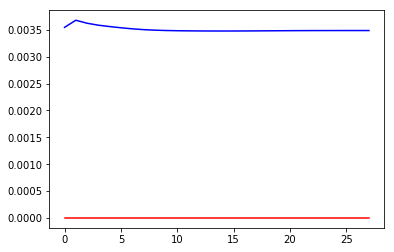

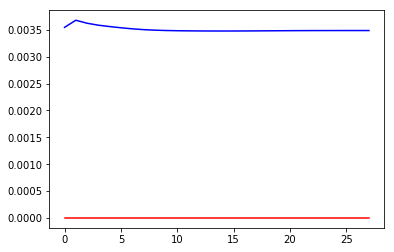

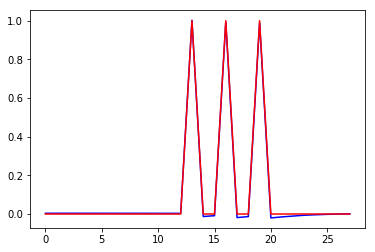

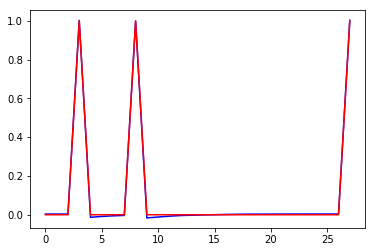

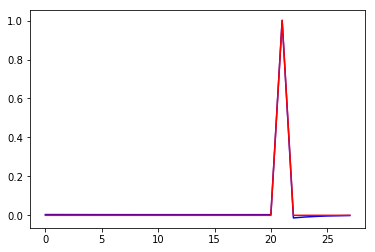

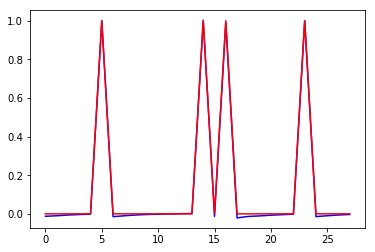

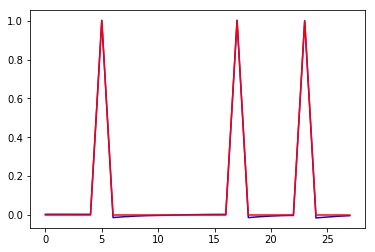

In [227]:
plot_predictions_vs_truth(toy_test_predictions,toy_test_purchase_matrix,100)

## MSE Error On Predictions

In [228]:
# report performance
rmse = sqrt(mean_squared_error(np.squeeze(toy_test_purchase_matrix), np.squeeze(toy_test_predictions)))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.046


# DMC Error

In [229]:
test_predictions_arr = toy_test_predictions.flatten()
test_groud_truth_arr = toy_test_groud_truth_matrix.flatten().astype(int)

test_days_mask = np.asarray([x != -1 for x in test_groud_truth_arr])

print("%s %s %s"%(test_predictions_arr.shape,test_groud_truth_arr.shape,test_days_mask.shape ))


(28000,) (28000,) (28000,)


In [230]:
test_predictions_filtered = test_predictions_arr[test_days_mask]
test_groud_truth_filtered = test_groud_truth_arr[test_days_mask]

print("%s %s"%(test_predictions_filtered.shape,test_groud_truth_filtered.shape))


(10506,) (10506,)


In [231]:
test_error = math.sqrt(((test_predictions_filtered - test_groud_truth_filtered)**2).sum())

In [232]:
print("Test DMC error: %f"%test_error)


Test DMC error: 59.032850
